In [1]:
# 02_baselines.ipynb
# Baseline Models for Cardiovascular Disease Prediction

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy csv from drive into colab temp storage
!cp "/content/drive/MyDrive/cardio-ml-project/cardio_train.csv" "/content/cardio_train.csv"

# load dataset
import pandas as pd
cardio = pd.read_csv("/content/cardio_train.csv", sep=";")
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# Feature Engineering

# BMI for cardio dataset
cardio['bmi'] = cardio['weight'] / (cardio['height']/100)**2

# blood pressure difference
cardio['bp_diff'] = cardio['ap_hi'] - cardio['ap_lo']

# convert age from days to years
cardio['age_years'] = (cardio['age'] / 365).astype(int)

In [10]:
# Features (X) and target (y)

X = cardio[['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_diff', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
y = cardio['cardio'] # 1 = disease, 0 = no disease

In [11]:
# Train-test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 80% train, 20% test

In [12]:
# Scale numeric features (KNN, SVM sensitive to feature scales)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

In [20]:
# Define baseline models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42), # probability=True required for ROC-AUC
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

from sklearn.neural_network import MLPClassifier

# Add simple neural network (baseline MLP)
models["Neural Net (MLP)"] = MLPClassifier(
    hidden_layer_sizes=(50,),  # one hidden layer with 50 neurons
    max_iter=300,              # max training iterations
    random_state=42
)

In [21]:
# Train and evaluate

results = [] # hold model performance metrics

for name, model in models.items():
  model.fit(X_train, y_train) # train on training data
  y_pred = model.predict(X_test) # make predictions (class labels: 0 or 1)
  y_proba = model.predict_proba(X_test)[:, 1] # predicted probabilities (for ROC-AUC)

  # collect metrics
  results.append({
      "Model": name,
      "Accuracy": accuracy_score(y_test, y_pred),
      "Precision": precision_score(y_test, y_pred),
      "Recall": recall_score(y_test, y_pred),
      "F1": f1_score(y_test, y_pred),
      "ROC-AUC": roc_auc_score(y_test, y_pred)
  })

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:41:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [22]:
# convert results to DataFrame for viewing
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC-AUC", ascending=False, inplace=True) # sort by best model

print(results_df)

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
6     Neural Net (MLP)  0.730500   0.740990  0.708262  0.724256  0.730487
5              XGBoost  0.730500   0.747125  0.696398  0.720870  0.730481
4                  SVM  0.724786   0.740254  0.692110  0.715373  0.724767
0  Logistic Regression  0.714214   0.731847  0.675672  0.702638  0.714192
2        Random Forest  0.709643   0.713350  0.700400  0.706816  0.709638
3                  KNN  0.645500   0.651603  0.624500  0.637764  0.645488
1        Decision Tree  0.637071   0.642464  0.617210  0.629584  0.637060


<Figure size 1200x600 with 0 Axes>

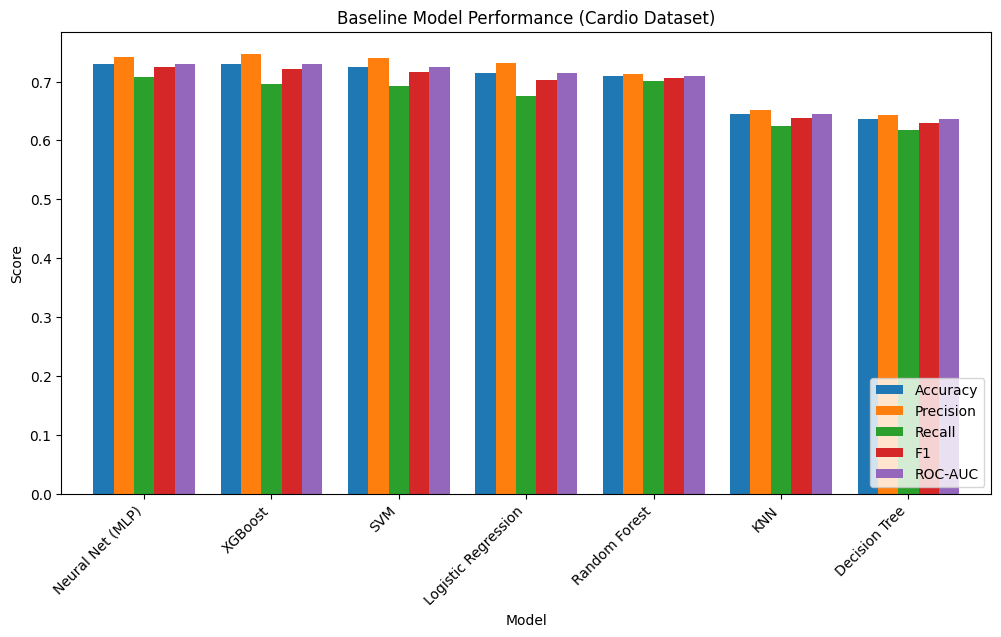

In [29]:
# Plot metrics for easier comparison
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

# grouped bar chart
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

ax = results_df.plot(x="Model", y=metrics, kind="bar", figsize=(12,6), width=0.8)
plt.title("Baseline Model Performance (Cardio Dataset)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="lower right")
plt.tight_layout
plt.show()

In [31]:
import os

# Define project and results path
project_path = "/content/drive/MyDrive/cardio-ml-project"
results_path = f"{project_path}/results"
os.makedirs(results_path, exist_ok=True)

# Save baseline results to Drive
results_df.to_csv(f"{results_path}/baseline_results.csv", index=False)
print(f"Baseline results saved to {results_path}/baseline_results.csv")

Baseline results saved to /content/drive/MyDrive/cardio-ml-project/results/baseline_results.csv


Evaluated 7 models total for baseline. The highest ROC-AUC was neural network (MLP) with 0.730. Neural network performed similar to XGBoost (simple NN and tree-based model). With this baseline, the next steps would be hyperparameter tuning and more neural network.